In [1]:
import pandas as pd, numpy as np, os
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v6.0.0_vicious_cycle/ciff_sam/2022_02_17_15_25_21/count_data/'

In [3]:
figname = 'model_6.0.0'

In [4]:
os.listdir(output_dir)

['wasting_transition_count.hdf',
 'wasting_transition_count.csv',
 'wasting_state_person_time.hdf',
 'deaths.csv',
 'wasting_state_person_time.csv',
 'deaths.hdf',
 'disease_transition_count.csv',
 'births.csv',
 'population.csv',
 'stunting_state_person_time.hdf',
 'ylds.csv',
 'ylls.csv',
 'disease_state_person_time.csv',
 'population.hdf',
 'ylls.hdf',
 'ylds.hdf',
 'disease_state_person_time.hdf',
 'births.hdf',
 'disease_transition_count.hdf',
 'stunting_state_person_time.csv']

In [5]:
state_pt = pd.read_csv(output_dir + 'disease_state_person_time.csv')
transitions = pd.read_csv(output_dir + 'disease_transition_count.csv')
deaths = pd.read_csv(output_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,0,female,2022,diarrheal_diseases,death,29,baseline,0.0,susceptible_to_child_wasting,early_neonatal
1,1,female,2022,diarrheal_diseases,death,29,baseline,0.0,mild_child_wasting,early_neonatal
2,2,female,2022,diarrheal_diseases,death,29,baseline,1.0,moderate_acute_malnutrition,early_neonatal
3,3,female,2022,diarrheal_diseases,death,29,baseline,1.0,severe_acute_malnutrition,early_neonatal
4,4,female,2022,diarrheal_diseases,death,29,baseline,0.0,susceptible_to_child_wasting,late_neonatal


In [6]:
groupby_cols = ['input_draw','wasting_state']

In [7]:
def calculate_transition_rates(groupby_cols):
    trans = transitions.loc[transitions.scenario=='baseline']
    trans['cause'] = trans['measure'].str.split('to_', expand=True)[2].str.split('_event_count', expand=True)[0]
    trans['measure'] = np.where(trans.measure.str.contains('to_susceptible_to'),'remission','incidence')
    trans = trans.groupby(groupby_cols+['cause','measure']).sum()
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
          .loc[state_pt.scenario=='baseline']
          .groupby(groupby_cols).sum())
    trans = (trans / pt)[['value']]
    trans = trans#.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause','measure']).describe(percentiles=[0.025,0.975])
    return trans

In [8]:
def calculate_incidence_rrs(strata_cols):
    t = calculate_transition_rates(strata_cols + ['input_draw','wasting_state']).reset_index()
    t = t.loc[t.measure=='incidence']
    tmrel = t.loc[t.wasting_state=='susceptible_to_child_wasting'].set_index(strata_cols + ['input_draw','cause'])[['value']]
    t = t.set_index(strata_cols + ['input_draw','cause','wasting_state'])[['value']] / tmrel
    t = t.groupby(strata_cols + ['cause','wasting_state']).describe(percentiles=[0.025,0.975])
    return t

In [9]:
calculate_incidence_rrs([])

value            \
                                                          count      mean   
cause                        wasting_state                                  
diarrheal_diseases           mild_child_wasting            12.0  1.076892   
                             moderate_acute_malnutrition   12.0  1.157290   
                             severe_acute_malnutrition     12.0  1.572588   
                             susceptible_to_child_wasting  12.0  1.000000   
lower_respiratory_infections mild_child_wasting            12.0  2.024703   
                             moderate_acute_malnutrition   12.0  4.622855   
                             severe_acute_malnutrition     12.0  5.515354   
                             susceptible_to_child_wasting  12.0  1.000000   
measles                      mild_child_wasting            12.0  1.105361   
                             moderate_acute_malnutrition   12.0  2.703856   
                             severe_acute_malnutrition     12.0  6.382092   
                             susceptible_to_child_wasting  12.0  1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            0.048046  1.020769   
                             moderate_acute_malnutrition   0.084922  1.052422   
                             severe_acute_malnutrition     0.090102  1.427391   
                             susceptible_to_child_wasting  0.000000  1.000000   
lower_respiratory_infections mild_child_wasting            0.438731  1.398164   
                             moderate_acute_malnutrition   0.995289  3.312962   
                             severe_acute_malnutrition     1.453264  3.298010   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.206487  0.841757   
                             moderate_acute_malnutrition   0.574864  1.630722   
                             severe_acute_malnutrition     1.940333  3.469825   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                               \
                                                               2.5%       50%   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            1.024759  1.062729   
                             moderate_acute_malnutrition   1.056983  1.136858   
                             severe_acute_malnutrition     1.440527  1.553173   
                             susceptible_to_child_wasting  1.000000  1.000000   
lower_respiratory_infections mild_child_wasting            1.431326  1.970305   
                             moderate_acute_malnutrition   3.356522  4.530570   
                             severe_acute_malnutrition     3.426574  5.563869   
                             susceptible_to_child_wasting  1.000000  1.000000   
measles                      mild_child_wasting            0.842035  1.090615   
                             moderate_acute_malnutrition   1.723070  2.605909   
                             severe_acute_malnutrition     3.731178  6.110739   
                             susceptible_to_child_wasting  1.000000  1.000000   

                                                                               
                                                              97.5%       max  
cause                        wasting_state                                     
diarrheal_diseases           mild_child_wasting            1.162130  1.167925  
                             moderate_acute_malnutrition   1.305127  1.310288  
                             severe_acute_malnutrition     1.701386  1

In [10]:
incidence_rrs = calculate_incidence_rrs(['age','sex'])
incidence_rrs

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.8/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.8/site-packages/numpy/lib/function_base.py:4012: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.8/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))


value  \
                                                                               count   
age           sex    cause                        wasting_state                        
1-5_months    female diarrheal_diseases           mild_child_wasting             4.0   
                                                  moderate_acute_malnutrition    3.0   
                                                  severe_acute_malnutrition      4.0   
                                                  susceptible_to_child_wasting   4.0   
                     lower_respiratory_infections mild_child_wasting             4.0   
...                                                                              ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting   3.0   
                     measles                      mild_child_wasting             0.0   
                                                  moderate_acute_malnutrition    0.0   
                                                  severe_acute_malnutrition      0.0   
                                                  susceptible_to_child_wasting   0.0   

                                                                                          \
                                                                                    mean   
age           sex    cause                        wasting_state                            
1-5_months    female diarrheal_diseases           mild_child_wasting            0.436689   
                                                  moderate_acute_malnutrition   0.267127   
                                                  severe_acute_malnutrition     0.438387   
                                                  susceptible_to_child_wasting  1.000000   
                     lower_respiratory_infections mild_child_wasting            0.348699   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  1.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     std   
age           sex    cause                        wasting_state                            
1-5_months    female diarrheal_diseases           mild_child_wasting            0.057313   
                                                  moderate_acute_malnutrition   0.231445   
                                                  severe_acute_malnutrition     0.051705   
                                                  susceptible_to_child_wasting  0.000000   
                     lower_respiratory_infections mild_child_wasting            0.125973   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  0.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     min   
age           sex    cause                        wasting_state                     

In [11]:
# artifact
from vivarium import Artifact
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf',
               filter_terms=['year_start == 2020', f'age_end <= 5'])

In [12]:
wasting_rrs = art.load('risk_factor.child_wasting.relative_risk')

In [13]:
wasting_rrs = (art.load('risk_factor.child_wasting.relative_risk')
               .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
               .reset_index())
wasting_rrs['age'] = np.where(wasting_rrs['age_start'] == 0, 'early_neonatal', #1
                                            np.where(wasting_rrs['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(wasting_rrs['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(wasting_rrs['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(wasting_rrs['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2

wasting_rrs.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,count,mean,std,min,2.5%,50%,97.5%,max,age
0,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
1,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat2,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
2,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat3,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
3,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat4,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
4,Female,0.0,0.019178,2020,2021,lower_respiratory_infections,incidence_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal


In [14]:
def plot_incidence_relative_risks(age, sex, cause, measure):
    width=0.4
    if measure == 'incidence_rate':
        s = incidence_rrs.reset_index()
    elif measure == 'CSMR':
        s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

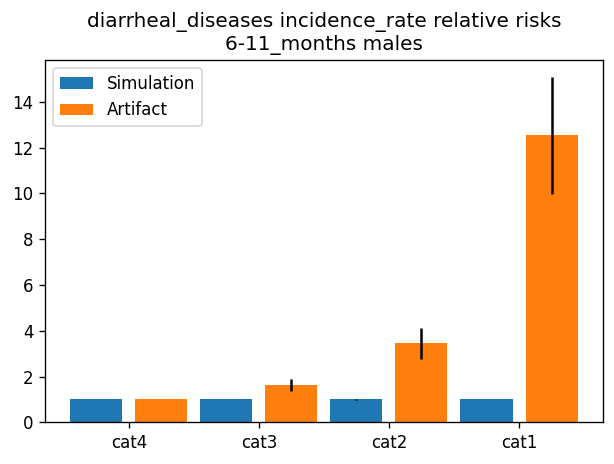

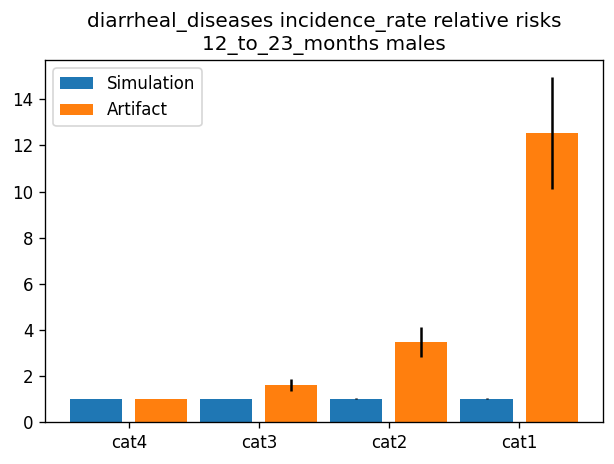

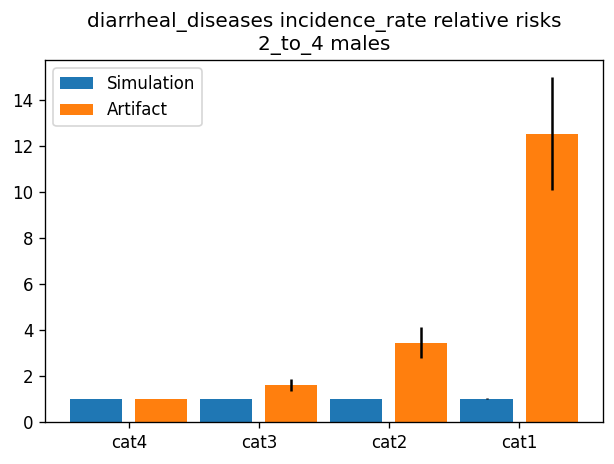

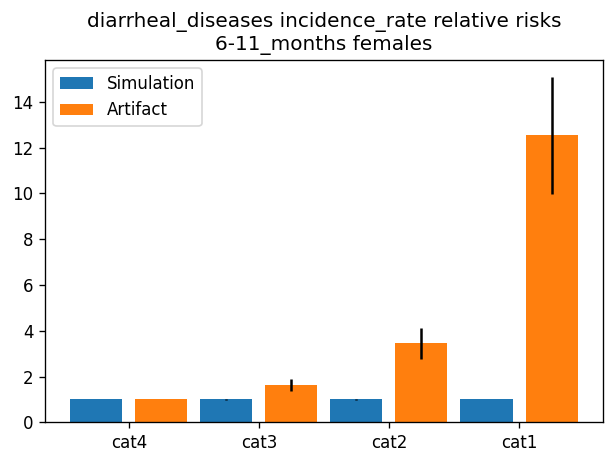

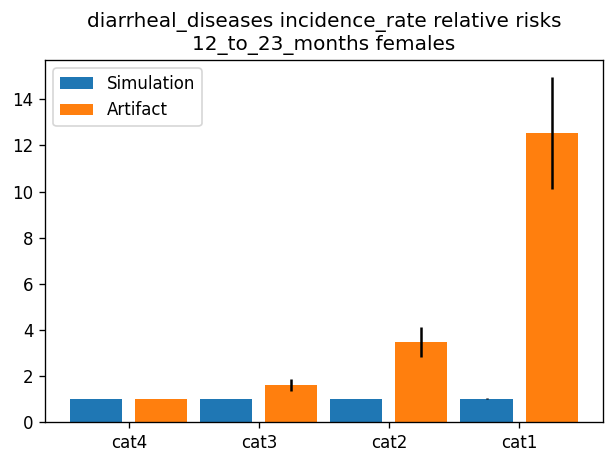

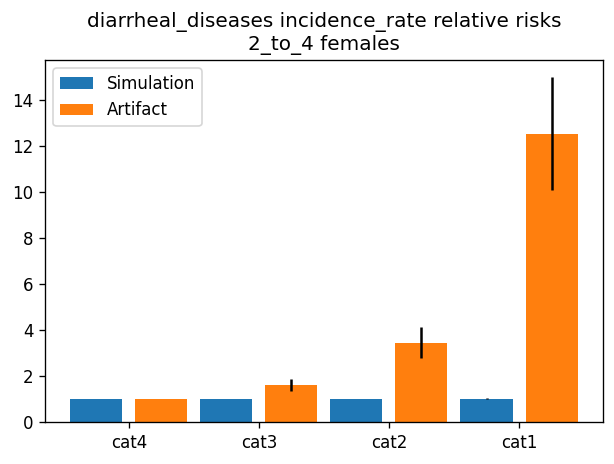

In [26]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'diarrheal_diseases', 'incidence_rate')

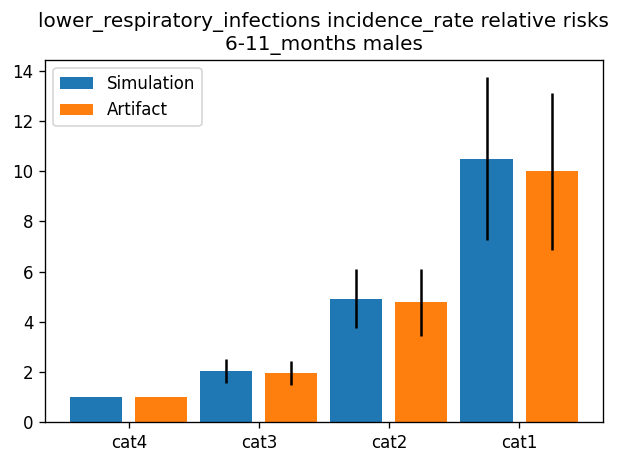

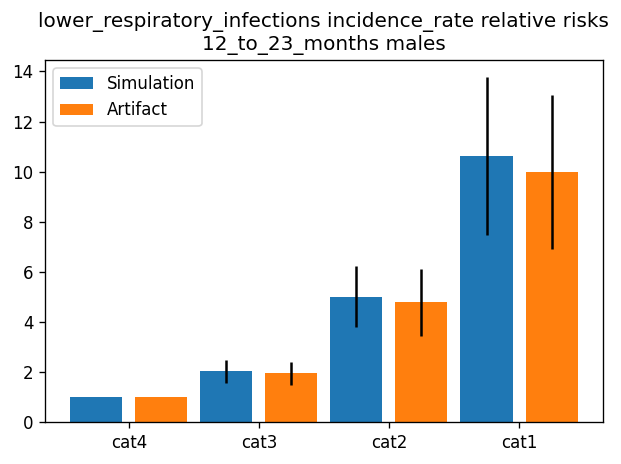

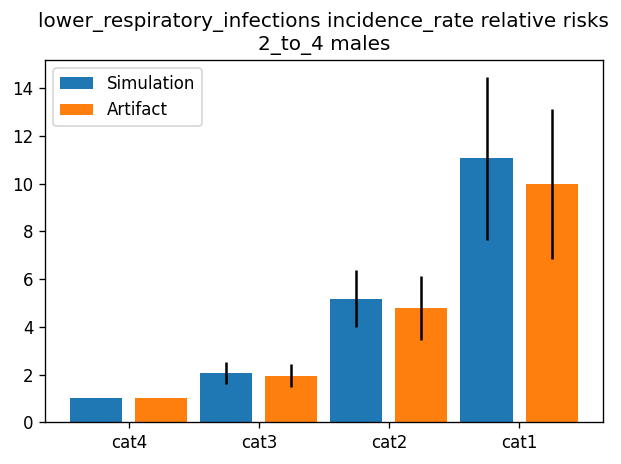

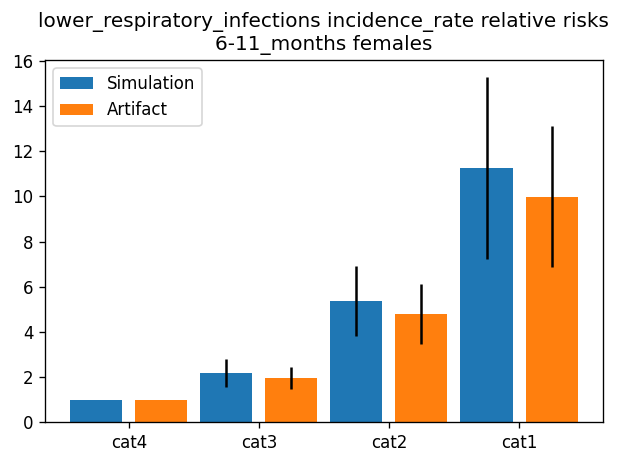

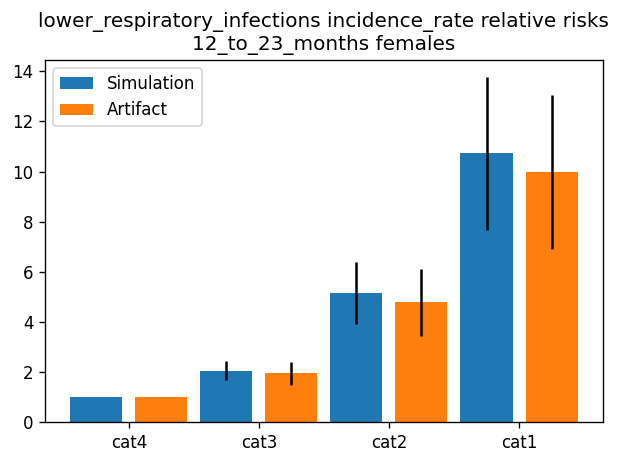

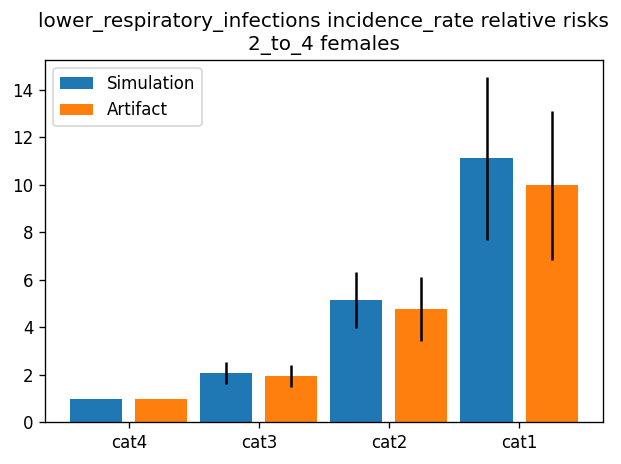

In [27]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'incidence_rate')

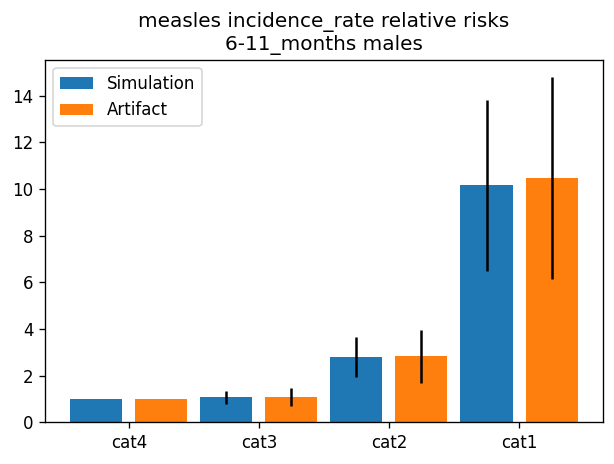

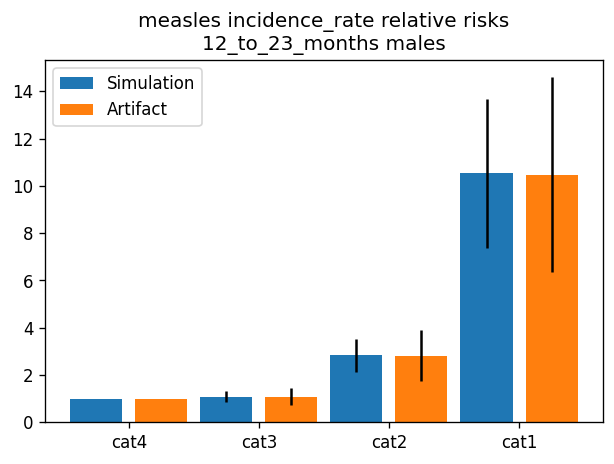

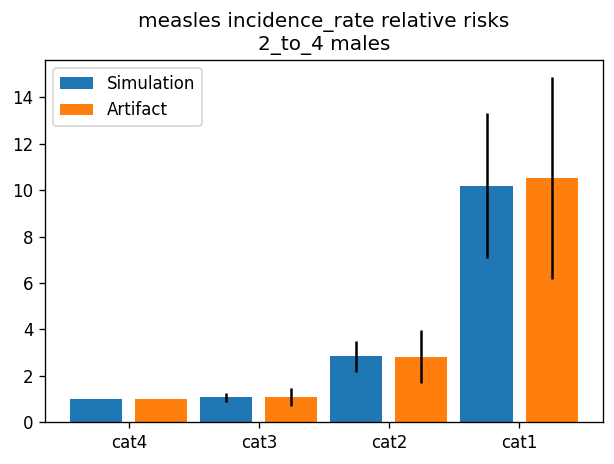

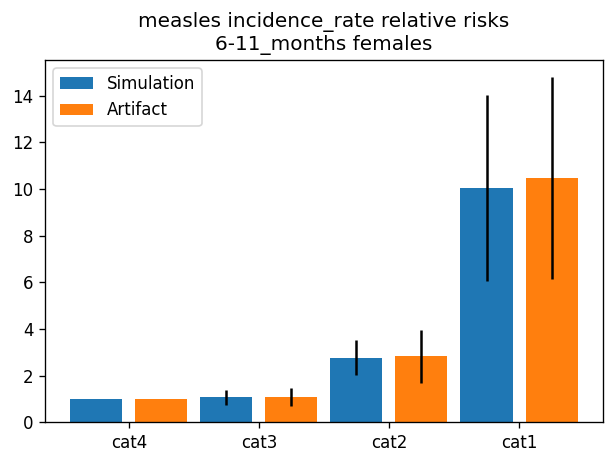

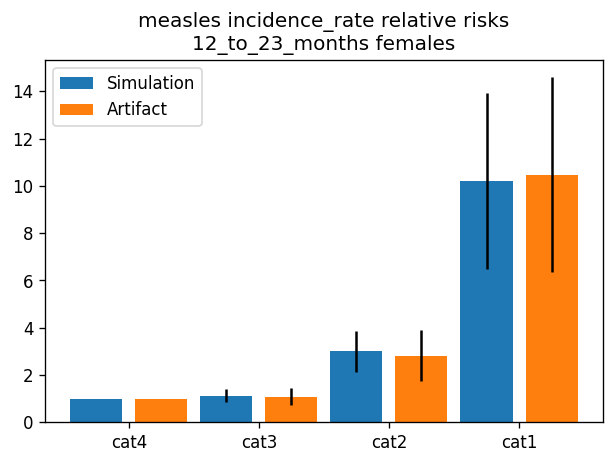

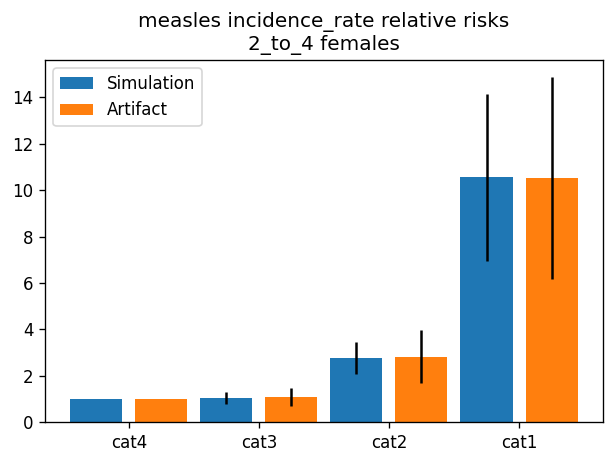

In [28]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'measles', 'incidence_rate')

In [35]:
def calculate_csmr_rrs(strata_cols):
    d = deaths.reset_index()
    d = d.loc[(d.scenario=='baseline')
             &(d.cause.isin(['diarrheal_diseases',
                            'lower_respiratory_infections',
                            'measles']))
             &(d.age.isin(['12_to_23_months','2_to_4']))]
    d = d.groupby(strata_cols + ['input_draw','wasting_state','cause']).sum()[['value']]
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
              .loc[state_pt.scenario=='baseline']
              .groupby(strata_cols + ['input_draw','wasting_state']).sum())[['value']]
    d = (d / pt).reset_index()
    d_tmrel = d.loc[d.wasting_state.str.contains('susc')].set_index(strata_cols + ['input_draw','cause'])[['value']]
    d = d.set_index(strata_cols + ['input_draw','cause','wasting_state']) / d_tmrel
    d = d.groupby(strata_cols + ['cause','wasting_state']).describe()
    return d

In [36]:
calculate_csmr_rrs([])

value            \
                                                          count      mean   
cause                        wasting_state                                  
diarrheal_diseases           mild_child_wasting            12.0  1.809938   
                             moderate_acute_malnutrition   12.0  5.593628   
                             severe_acute_malnutrition     12.0  2.533158   
                             susceptible_to_child_wasting  12.0  1.000000   
lower_respiratory_infections mild_child_wasting            12.0  1.744486   
                             moderate_acute_malnutrition   12.0  3.327321   
                             severe_acute_malnutrition     12.0  1.463804   
                             susceptible_to_child_wasting  12.0  1.000000   
measles                      mild_child_wasting            12.0  1.129434   
                             moderate_acute_malnutrition   12.0  2.036713   
                             severe_acute_malnutrition     12.0  1.389925   
                             susceptible_to_child_wasting  12.0  1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            0.468610  1.146110   
                             moderate_acute_malnutrition   1.465174  3.969300   
                             severe_acute_malnutrition     0.706396  1.631348   
                             susceptible_to_child_wasting  0.000000  1.000000   
lower_respiratory_infections mild_child_wasting            0.448978  1.153651   
                             moderate_acute_malnutrition   0.914145  1.876133   
                             severe_acute_malnutrition     0.684099  0.403726   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.636891  0.405664   
                             moderate_acute_malnutrition   0.920820  0.466548   
                             severe_acute_malnutrition     0.523741  0.597922   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                               \
                                                                25%       50%   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            1.433927  1.739989   
                             moderate_acute_malnutrition   4.133730  5.551484   
                             severe_acute_malnutrition     1.951426  2.510112   
                             susceptible_to_child_wasting  1.000000  1.000000   
lower_respiratory_infections mild_child_wasting            1.412982  1.588852   
                             moderate_acute_malnutrition   2.827799  3.373906   
                             severe_acute_malnutrition     1.144355  1.483409   
                             susceptible_to_child_wasting  1.000000  1.000000   
measles                      mild_child_wasting            0.658243  1.008567   
                             moderate_acute_malnutrition   1.428183  2.062529   
                             severe_acute_malnutrition     1.107669  1.375680   
                             susceptible_to_child_wasting  1.000000  1.000000   

                                                                               
                                                                75%       max  
cause                        wasting_state                                     
diarrheal_diseases           mild_child_wasting            2.134221  2.683959  
                             moderate_acute_malnutrition   6.632544  7.932927  
                             severe_acute_malnutrition     3.109486  3

In [37]:
csmr_rrs = calculate_csmr_rrs(['age','sex'])
csmr_rrs.head()

value  \
                                                                                 count   
age             sex    cause                        wasting_state                        
12_to_23_months female diarrheal_diseases           mild_child_wasting            12.0   
                                                    moderate_acute_malnutrition   12.0   
                                                    severe_acute_malnutrition     12.0   
                                                    susceptible_to_child_wasting  12.0   
                       lower_respiratory_infections mild_child_wasting            12.0   

                                                                                             \
                                                                                       mean   
age             sex    cause                        wasting_state                             
12_to_23_months female diarrheal_diseases           mild_child_wasting             2.034870   
                                                    moderate_acute_malnutrition    7.296128   
                                                    severe_acute_malnutrition     15.873847   
                                                    susceptible_to_child_wasting   1.000000   
                       lower_respiratory_infections mild_child_wasting             1.767466   

                                                                                            \
                                                                                       std   
age             sex    cause                        wasting_state                            
12_to_23_months female diarrheal_diseases           mild_child_wasting            0.551878   
                                                    moderate_acute_malnutrition   2.398245   
                                                    severe_acute_malnutrition     4.050843   
                                                    susceptible_to_child_wasting  0.000000   
                       lower_respiratory_infections mild_child_wasting            0.676032   

                                                                                            \
                                                                                       min   
age             sex    cause                        wasting_state                            
12_to_23_months female diarrheal_diseases           mild_child_wasting            1.161358   
                                                    moderate_acute_malnutrition   4.359571   
                                                    severe_acute_malnutrition     9.189218   
                                                    susceptible_to_child_wasting  1.000000   
                       lower_respiratory_infections mild_child_wasting            0.785837   

                                                                                             \
                                                                                        25%   
age             sex    cause                        wasting_state                             
12_to_23_months female diarrheal_diseases           mild_child_wasting             1.666615   
                                                    moderate_acute_malnutrition    5.024277   
                                                    severe_acute_malnutrition     12.594026   
                                                    susceptible_to_child_wasting   1.000000   
                       lower_respiratory_infections mild_child_wasting             1.069830   

                                                                                             \
                                                                                        50%   
age             sex    cause                        wasting_state                             
12_to_23_months female diarrheal_diseases      

In [38]:
def plot_csmr_relative_risks(age, sex, cause, measure):
    width=0.4
    s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

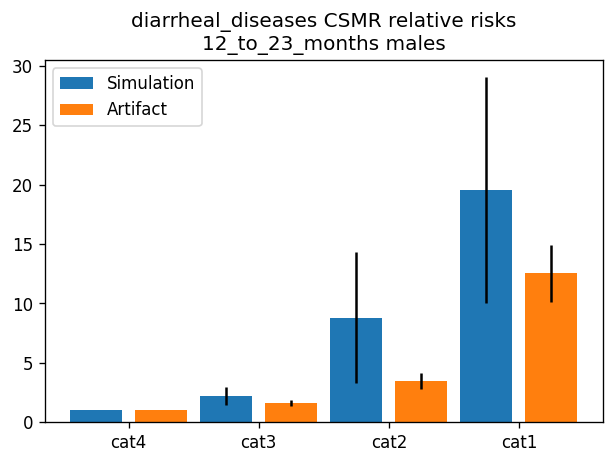

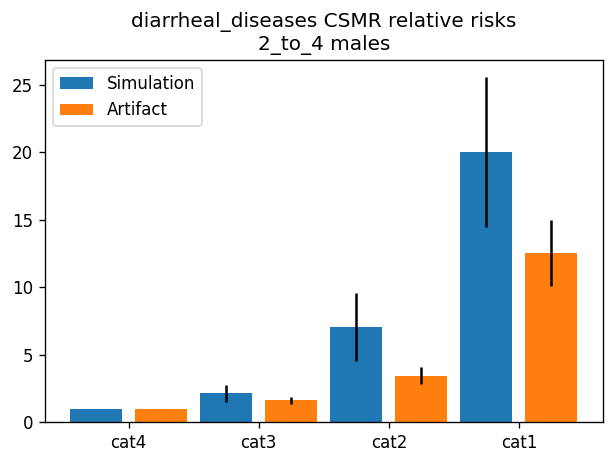

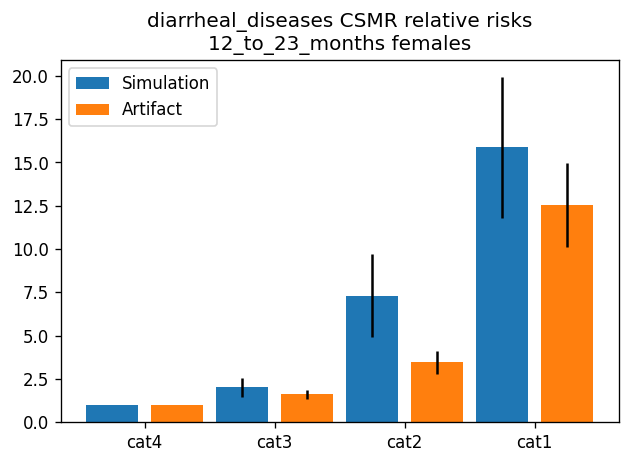

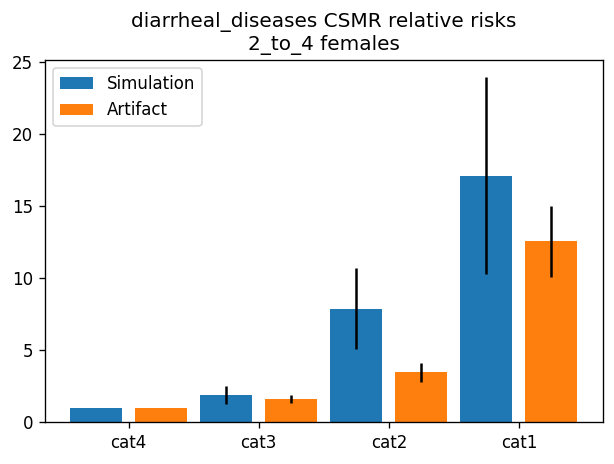

In [39]:
for sex in ['male','female']:
    for age in ['12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'diarrheal_diseases', 'CSMR')

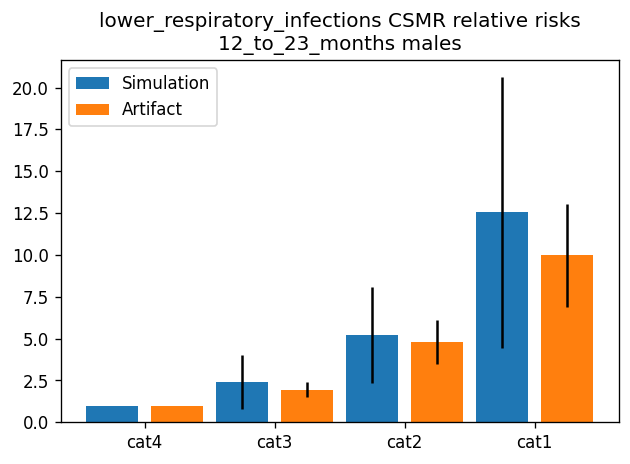

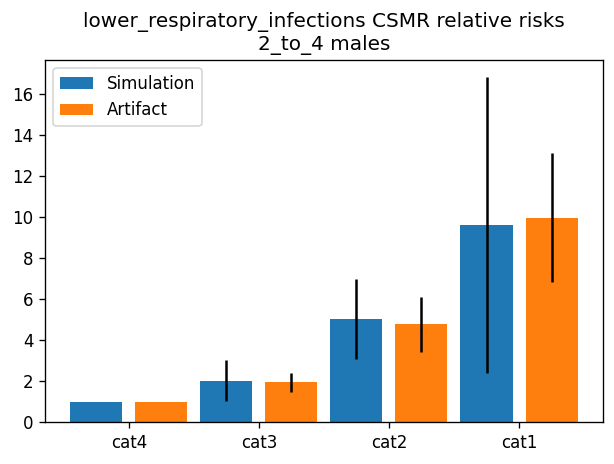

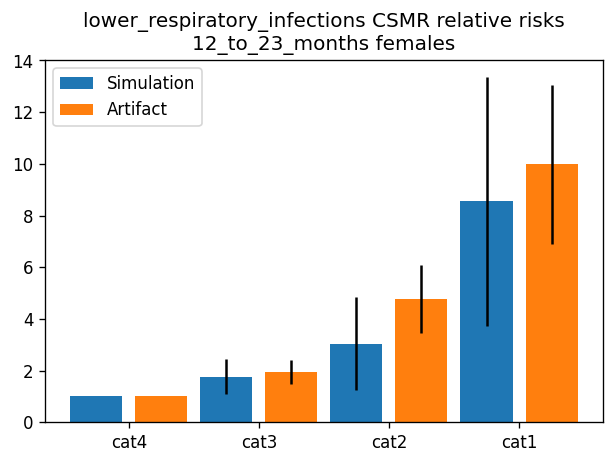

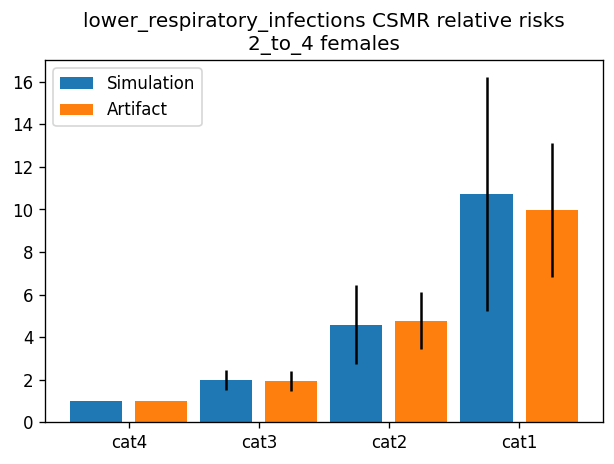

In [40]:
for sex in ['male','female']:
    for age in ['12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'CSMR')